In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d
from torch.utils.data import Dataset, DataLoader

In [5]:
# Other
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import time
import warnings
from pprint import pprint

In [6]:
import torchvision.transforms as tr

In [7]:
class SiamUnet_conc(nn.Module):
    """SiamUnet_conc segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_conc, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(384, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(192, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(96, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(48, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)



        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)


        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)
        print('Stage1'+str(x1p.shape))
        print('Stage2'+str(x2p.shape))
        print('Stage3'+str(x3p.shape))
        print('Stage4'+str(x4p.shape))


        ####################################################
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)
        print('Stage1'+str(x1p.shape))
        print('Stage2'+str(x2p.shape))
        print('Stage3'+str(x3p.shape))
        print('Stage4'+str(x4p.shape))


        ####################################################
        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43_1, x43_2), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33_1, x33_2), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22_1, x22_2), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12_1, x12_2), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)

In [8]:
# Global Variables' Definitions

PATH_TO_DATASET = "/content/drive/My Drive/Colab Notebooks/OISD"
IS_PROTOTYPE = False

FP_MODIFIER = 10 # Tuning parameter, use 1 if unsure

BATCH_SIZE = 32
PATCH_SIDE = 96
N_EPOCHS = 10

NORMALISE_IMGS = True

TRAIN_STRIDE = int(PATCH_SIDE/2) - 1

LOAD_TRAINED = False

DATA_AUG = True


print('DEFINITIONS OK')

DEFINITIONS OK


In [9]:
# Functions

def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""

    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape

    # pad if necessary
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])

    return np.pad(I,((0,p0),(0,p1)),'edge')

In [10]:
def read_sentinel_img_4(path):
    """Read cropped Sentinel-2 image: RGB and NIR bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(os.path.join(path, "B04.tif"))
    g = io.imread(os.path.join(path,  "B03.tif"))
    b = io.imread(os.path.join(path,  "B02.tif"))
    nir = io.imread(os.path.join(path,"B08.tif"))

    I = np.stack((r,g,b,nir),axis=2).astype('float')

    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

In [11]:
def read_sentinel_img_trio(path):
    """Read cropped Sentinel-2 image pair and change map."""
#     read images
    I1 = read_sentinel_img_4(path + '/imgs_1/')
    I2 = read_sentinel_img_4(path + '/imgs_2/')
    cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0

    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')


    return I1, I2, cm

In [12]:
def reshape_for_torch(I):
    """Transpose image for PyTorch coordinates."""
#     out = np.swapaxes(I,1,2)
#     out = np.swapaxes(out,0,1)
#     out = out[np.newaxis,:]
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)

In [13]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io
from PIL import Image
from tqdm import tqdm
import numpy as np
from math import ceil
from scipy.ndimage import zoom

In [14]:
class ChangeDetectionDataset(Dataset):
    """Change Detection dataset class, used for both training and test data."""

    def __init__(self, path, train=True, patch_side=96, stride=None, use_all_bands=False, transform=None):
        """
        Args:
            path (string): Directory containing the dataset.
            train (bool): If True, loads training data. If False, loads test data.
            patch_side (int): Size of the patch to extract.
            stride (int): Stride for extracting patches.
            use_all_bands (bool): Whether to use all bands in Sentinel-2 data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        # Initialize basics
        self.transform = transform
        self.path = path
        self.patch_side = patch_side
        self.stride = stride if stride else 1

        # Define the correct folder and file based on training or test data
        if train:
            img1_dir = 'Input 1'
            img2_dir = 'Input 2'
            mask_dir = 'Masks'
        else:
            img1_dir = 'Input_1_test'
            img2_dir = 'Input_2_test'
            mask_dir = 'Masks_test'

        # Load image folder names dynamically
        self.names = sorted(os.listdir(os.path.join(path, img1_dir)))  # Correctly loads the city names
        self.n_imgs = len(self.names)

        n_pix = 0
        true_pix = 0

        # Load images
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []

        # Loop over all image names (city folders)
        for im_name in tqdm(self.names):
            # Load image pair and change map
            I1, I2, cm = self.read_img_pair_and_change_map(im_name, img1_dir, img2_dir, mask_dir)

            # Reshape and store the images and change maps
            self.imgs_1[im_name] = reshape_for_torch(I1)
            self.imgs_2[im_name] = reshape_for_torch(I2)
            self.change_maps[im_name] = cm

            # Patch calculation
            s = cm.shape
            n_pix += np.prod(s)
            true_pix += cm.sum()

            # Calculate the number of patches
            s = self.imgs_1[im_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            self.n_patches_per_image[im_name] = n_patches_i
            self.n_patches += n_patches_i

            # Generate patch coordinates
            for i in range(n1):
                for j in range(n2):
                    current_patch_coords = (im_name,
                                            [self.stride * i, self.stride * i + self.patch_side, self.stride * j, self.stride * j + self.patch_side],
                                            [self.stride * (i + 1), self.stride * (j + 1)])
                    self.patch_coords.append(current_patch_coords)

        # Assign class weights
        self.weights = [FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]

    def read_img_pair_and_change_map(self, im_name, img1_dir, img2_dir, mask_dir):
        """Reads image pair and change map based on directories."""
        I1 = read_sentinel_img_4(os.path.join(self.path, img1_dir, im_name))
        I2 = read_sentinel_img_4(os.path.join(self.path, img2_dir, im_name))

        # Correct file extension for change maps ('.png' based on your previous description)
        cm_path = os.path.join(self.path, mask_dir, im_name , 'cm.png')
        cm = io.imread(cm_path, as_gray=True) != 0

        return I1, I2, cm

    def __len__(self):
        return self.n_patches
    import torch.nn.functional as F

    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name]


    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]

        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]

        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        label = torch.from_numpy(1 * np.array(label)).float()

        sample = {'I1': I1, 'I2': I2, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    '''def __getitem__(self, idx):
    # Get the patch coordinates
      current_patch_coords = self.patch_coords[idx]
      im_name = current_patch_coords[0]
      limits = current_patch_coords[1]

      # Extract patches
      I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
      I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
      label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
      label = torch.from_numpy(1 * np.array(label)).float()

      # Find the maximum patch size (you can specify if the max size is fixed)
      max_h, max_w = self.patch_side, self.patch_side

      # Pad images and labels if they are smaller than the maximum size
      I1_padded = pad_to_same_size([I1], max_h, max_w)[0]
      I2_padded = pad_to_same_size([I2], max_h, max_w)[0]
      label_padded = pad_to_same_size([label], max_h, max_w)[0]

      sample = {'I1': I1_padded, 'I2': I2_padded, 'label': label_padded}

      # Apply any additional transformations if required
      if self.transform:
          sample = self.transform(sample)

      return sample'''




In [15]:
class RandomFlip(object):
    """Flip randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']

        if random.random() > 0.5:
            I1 =  I1.numpy()[:,:,::-1].copy()
            I1 = torch.from_numpy(I1)
            I2 =  I2.numpy()[:,:,::-1].copy()
            I2 = torch.from_numpy(I2)
            label =  label.numpy()[:,::-1].copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}

In [16]:
class RandomRot(object):
    """Rotate randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']

        n = random.randint(0, 3)
        if n:
            I1 =  sample['I1'].numpy()
            I1 = np.rot90(I1, n, axes=(1, 2)).copy()
            I1 = torch.from_numpy(I1)
            I2 =  sample['I2'].numpy()
            I2 = np.rot90(I2, n, axes=(1, 2)).copy()
            I2 = torch.from_numpy(I2)
            label =  sample['label'].numpy()
            label = np.rot90(label, n, axes=(0, 1)).copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}





print('UTILS OK')

UTILS OK


In [17]:
# Dataset


if DATA_AUG:
    data_transform = tr.Compose([RandomFlip(), RandomRot()])
else:
    data_transform = None

train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE, transform=data_transform)
weights = torch.FloatTensor(train_dataset.weights).cuda()
print(weights)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers=2)

print('DATASETS OK')

100%|██████████| 14/14 [01:45<00:00,  7.56s/it]


tensor([0.4595, 1.9540], device='cuda:0')


100%|██████████| 10/10 [01:14<00:00,  7.48s/it]

DATASETS OK


In [18]:
net, net_name = SiamUnet_conc(4, 2), 'FC-Siam-conc'
net.cuda()

criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output

print('NETWORK OK')

NETWORK OK


In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))

Number of trainable parameters: 1546130


In [20]:
# net.load_state_dict(torch.load('net-best_epoch-1_fm-0.7394933126157746.pth.tar'))

def train(n_epochs = N_EPOCHS, save = True):
    t = np.linspace(1, n_epochs, n_epochs)

    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t

#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0

    lss = 1000
    best_lss = 1000

    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)


    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)


    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)


    for epoch_index in tqdm(range(n_epochs)):
        net.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = batch['I1'].float().cuda()
            I2  =batch['I2'].float().cuda()
            label = torch.squeeze(batch['label'].cuda())

            optimizer.zero_grad()
            output = net(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()

        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_dataset)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]

#         epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1], label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1], label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1], label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())


#         mean_acc = (epoch_test_nochange_accuracy[epoch_index] + epoch_test_change_accuracy[epoch_index])/2
#         if mean_acc > best_mean_acc:
#             best_mean_acc = mean_acc
#             save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_acc-' + str(mean_acc) + '.pth.tar'
#             torch.save(net.state_dict(), save_str)


#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(net.state_dict(), save_str)

        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(net.state_dict(), save_str)


#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)

    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}

    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)

    return out

L = 1024
N = 2

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)

        s = cm_full.shape


        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = jj
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = torch.unsqueeze(I1, 0).float().cuda()
                I2 = torch.unsqueeze(I2, 0).float().cuda()
                cm = torch.unsqueeze(torch.tensor(1.0 * cm), 0).float().cuda()



                output = net(I1, I2)
                loss = criterion(output, cm.long())
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1

                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()

                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()

    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count

    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)

    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]

    return net_loss, net_accuracy, class_accuracy, pr_rec






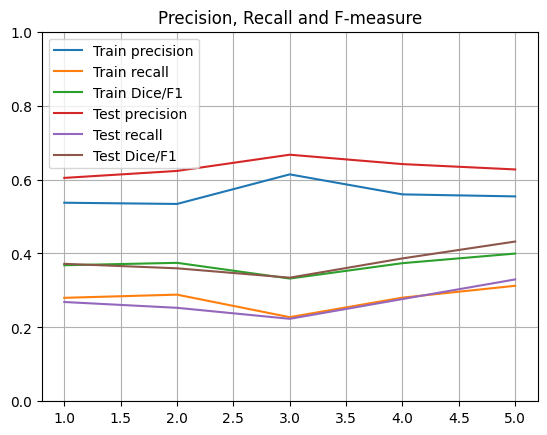

 50%|█████     | 5/10 [47:00<47:02, 564.51s/it]

Epoch: 6 of 10
Stage1torch.Size([32, 16, 48, 48])
Stage2torch.Size([32, 32, 24, 24])
Stage3torch.Size([32, 64, 12, 12])
Stage4torch.Size([32, 128, 6, 6])
Stage1torch.Size([32, 16, 48, 48])
Stage2torch.Size([32, 32, 24, 24])
Stage3torch.Size([32, 64, 12, 12])
Stage4torch.Size([32, 128, 6, 6])
Stage1torch.Size([32, 16, 48, 48])
Stage2torch.Size([32, 32, 24, 24])
Stage3torch.Size([32, 64, 12, 12])
Stage4torch.Size([32, 128, 6, 6])
Stage1torch.Size([32, 16, 48, 48])
Stage2torch.Size([32, 32, 24, 24])
Stage3torch.Size([32, 64, 12, 12])
Stage4torch.Size([32, 128, 6, 6])
Stage1torch.Size([32, 16, 48, 48])
Stage2torch.Size([32, 32, 24, 24])
Stage3torch.Size([32, 64, 12, 12])
Stage4torch.Size([32, 128, 6, 6])
Stage1torch.Size([32, 16, 48, 48])
Stage2torch.Size([32, 32, 24, 24])
Stage3torch.Size([32, 64, 12, 12])
Stage4torch.Size([32, 128, 6, 6])
Stage1torch.Size([32, 16, 48, 48])
Stage2torch.Size([32, 32, 24, 24])
Stage3torch.Size([32, 64, 12, 12])
Stage4torch.Size([32, 128, 6, 6])
Stage1torch.

In [ ]:

if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)

In [22]:

if not LOAD_TRAINED:
    torch.save(net.state_dict(), 'net_final.pth.tar')
    print('SAVE OK')

SAVE OK


In [25]:
def save_test_results(dset):
    for name in tqdm(dset.names):
        with warnings.catch_warnings():
            I1, I2, cm = dset.get_img(name)
            I1 = (torch.unsqueeze(I1, 0).float()).cuda()
            I2 = (torch.unsqueeze(I2, 0).float()).cuda()
            out = net(I1, I2)
            _, predicted = torch.max(out.data, 1)
            I = np.stack((255*cm, 255*np.squeeze(predicted.cpu().numpy()), 255*cm), 2).astype(np.uint8)

            io.imsave(f'{net_name}-{name}.png',I)



t_start = time.time()
# save_test_results(train_dataset)
save_test_results(test_dataset)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))

 20%|██        | 2/10 [00:00<00:00, 16.82it/s]

Stage1torch.Size([1, 16, 216, 234])
Stage2torch.Size([1, 32, 108, 117])
Stage3torch.Size([1, 64, 54, 58])
Stage4torch.Size([1, 128, 27, 29])
Stage1torch.Size([1, 16, 216, 234])
Stage2torch.Size([1, 32, 108, 117])
Stage3torch.Size([1, 64, 54, 58])
Stage4torch.Size([1, 128, 27, 29])
Stage1torch.Size([1, 16, 365, 272])
Stage2torch.Size([1, 32, 182, 136])
Stage3torch.Size([1, 64, 91, 68])
Stage4torch.Size([1, 128, 45, 34])
Stage1torch.Size([1, 16, 365, 272])
Stage2torch.Size([1, 32, 182, 136])
Stage3torch.Size([1, 64, 91, 68])
Stage4torch.Size([1, 128, 45, 34])
Stage1torch.Size([1, 16, 387, 317])
Stage2torch.Size([1, 32, 193, 158])
Stage3torch.Size([1, 64, 96, 79])
Stage4torch.Size([1, 128, 48, 39])
Stage1torch.Size([1, 16, 387, 317])
Stage2torch.Size([1, 32, 193, 158])
Stage3torch.Size([1, 64, 96, 79])
Stage4torch.Size([1, 128, 48, 39])


 40%|████      | 4/10 [00:00<00:00, 11.97it/s]

Stage1torch.Size([1, 16, 412, 358])
Stage2torch.Size([1, 32, 206, 179])
Stage3torch.Size([1, 64, 103, 89])
Stage4torch.Size([1, 128, 51, 44])
Stage1torch.Size([1, 16, 412, 358])
Stage2torch.Size([1, 32, 206, 179])
Stage3torch.Size([1, 64, 103, 89])
Stage4torch.Size([1, 128, 51, 44])
Stage1torch.Size([1, 16, 272, 279])
Stage2torch.Size([1, 32, 136, 139])
Stage3torch.Size([1, 64, 68, 69])
Stage4torch.Size([1, 128, 34, 34])
Stage1torch.Size([1, 16, 272, 279])
Stage2torch.Size([1, 32, 136, 139])
Stage3torch.Size([1, 64, 68, 69])
Stage4torch.Size([1, 128, 34, 34])
Stage1torch.Size([1, 16, 213, 225])
Stage2torch.Size([1, 32, 106, 112])
Stage3torch.Size([1, 64, 53, 56])
Stage4torch.Size([1, 128, 26, 28])
Stage1torch.Size([1, 16, 213, 225])
Stage2torch.Size([1, 32, 106, 112])
Stage3torch.Size([1, 64, 53, 56])
Stage4torch.Size([1, 128, 26, 28])
Stage1torch.Size([1, 16, 120, 192])
Stage2torch.Size([1, 32, 60, 96])
Stage3torch.Size([1, 64, 30, 48])
Stage4torch.Size([1, 128, 15, 24])
Stage1torch.S

100%|██████████| 10/10 [00:00<00:00, 16.47it/s]

Stage1torch.Size([1, 16, 176, 213])
Stage2torch.Size([1, 32, 88, 106])
Stage3torch.Size([1, 64, 44, 53])
Stage4torch.Size([1, 128, 22, 26])
Stage1torch.Size([1, 16, 176, 213])
Stage2torch.Size([1, 32, 88, 106])
Stage3torch.Size([1, 64, 44, 53])
Stage4torch.Size([1, 128, 22, 26])
Stage1torch.Size([1, 16, 319, 344])
Stage2torch.Size([1, 32, 159, 172])
Stage3torch.Size([1, 64, 79, 86])
Stage4torch.Size([1, 128, 39, 43])
Stage1torch.Size([1, 16, 319, 344])
Stage2torch.Size([1, 32, 159, 172])
Stage3torch.Size([1, 64, 79, 86])
Stage4torch.Size([1, 128, 39, 43])
Stage1torch.Size([1, 16, 229, 238])
Stage2torch.Size([1, 32, 114, 119])
Stage3torch.Size([1, 64, 57, 59])
Stage4torch.Size([1, 128, 28, 29])
Stage1torch.Size([1, 16, 229, 238])
Stage2torch.Size([1, 32, 114, 119])
Stage3torch.Size([1, 64, 57, 59])
Stage4torch.Size([1, 128, 28, 29])
Elapsed time: 0.6123435497283936


  0%|          | 0/10 [00:00<?, ?it/s]

Stage1torch.Size([1, 16, 216, 234])
Stage2torch.Size([1, 32, 108, 117])
Stage3torch.Size([1, 64, 54, 58])
Stage4torch.Size([1, 128, 27, 29])
Stage1torch.Size([1, 16, 216, 234])
Stage2torch.Size([1, 32, 108, 117])
Stage3torch.Size([1, 64, 54, 58])
Stage4torch.Size([1, 128, 27, 29])


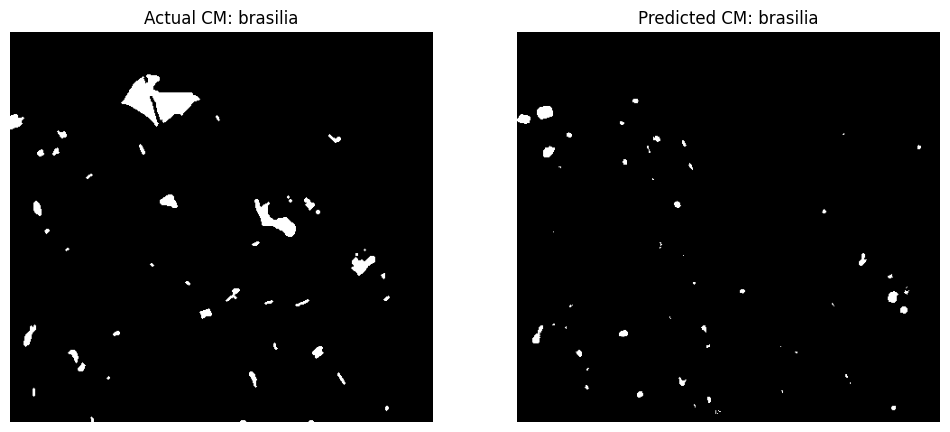

 10%|█         | 1/10 [00:00<00:03,  2.30it/s]

Stage1torch.Size([1, 16, 365, 272])
Stage2torch.Size([1, 32, 182, 136])
Stage3torch.Size([1, 64, 91, 68])
Stage4torch.Size([1, 128, 45, 34])
Stage1torch.Size([1, 16, 365, 272])
Stage2torch.Size([1, 32, 182, 136])
Stage3torch.Size([1, 64, 91, 68])
Stage4torch.Size([1, 128, 45, 34])


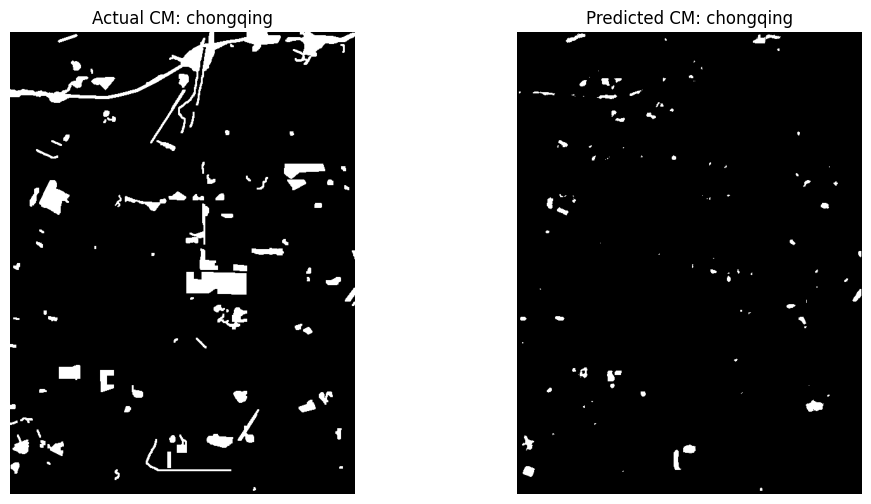

 20%|██        | 2/10 [00:00<00:03,  2.07it/s]

Stage1torch.Size([1, 16, 387, 317])
Stage2torch.Size([1, 32, 193, 158])
Stage3torch.Size([1, 64, 96, 79])
Stage4torch.Size([1, 128, 48, 39])
Stage1torch.Size([1, 16, 387, 317])
Stage2torch.Size([1, 32, 193, 158])
Stage3torch.Size([1, 64, 96, 79])
Stage4torch.Size([1, 128, 48, 39])


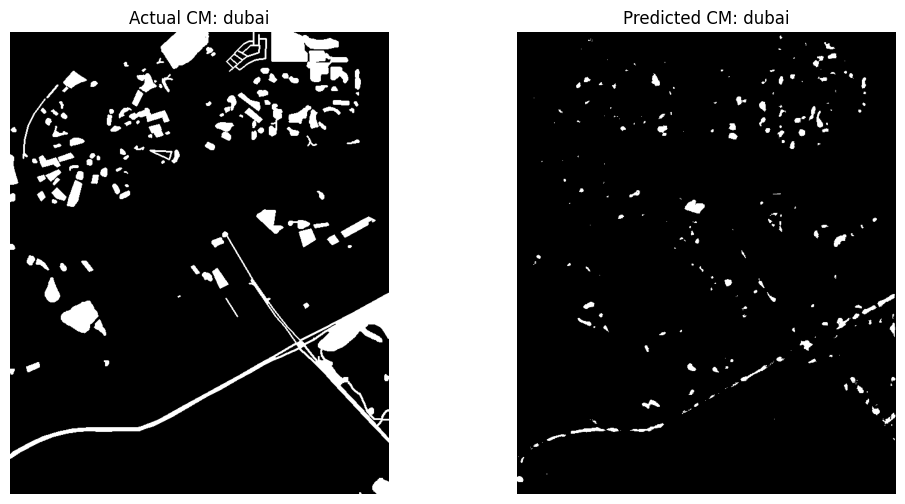

 30%|███       | 3/10 [00:01<00:03,  1.93it/s]

Stage1torch.Size([1, 16, 412, 358])
Stage2torch.Size([1, 32, 206, 179])
Stage3torch.Size([1, 64, 103, 89])
Stage4torch.Size([1, 128, 51, 44])
Stage1torch.Size([1, 16, 412, 358])
Stage2torch.Size([1, 32, 206, 179])
Stage3torch.Size([1, 64, 103, 89])
Stage4torch.Size([1, 128, 51, 44])


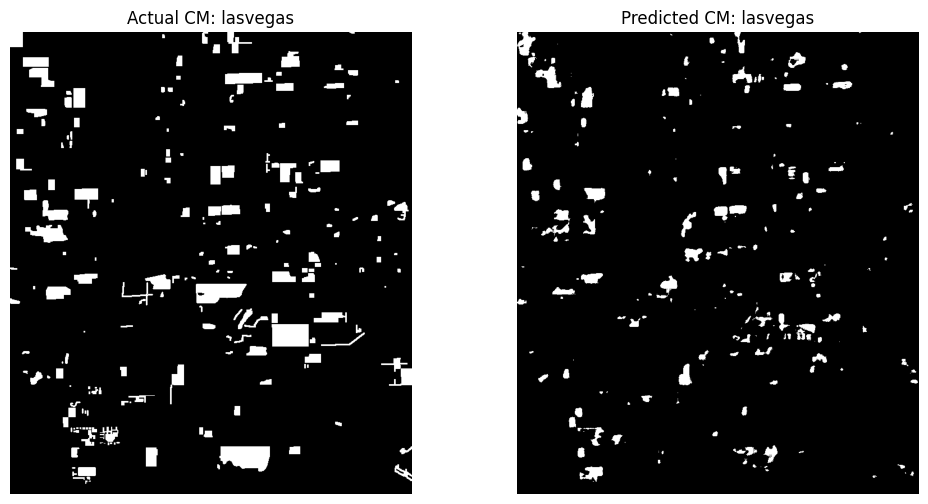

 40%|████      | 4/10 [00:01<00:03,  2.00it/s]

Stage1torch.Size([1, 16, 272, 279])
Stage2torch.Size([1, 32, 136, 139])
Stage3torch.Size([1, 64, 68, 69])
Stage4torch.Size([1, 128, 34, 34])
Stage1torch.Size([1, 16, 272, 279])
Stage2torch.Size([1, 32, 136, 139])
Stage3torch.Size([1, 64, 68, 69])
Stage4torch.Size([1, 128, 34, 34])


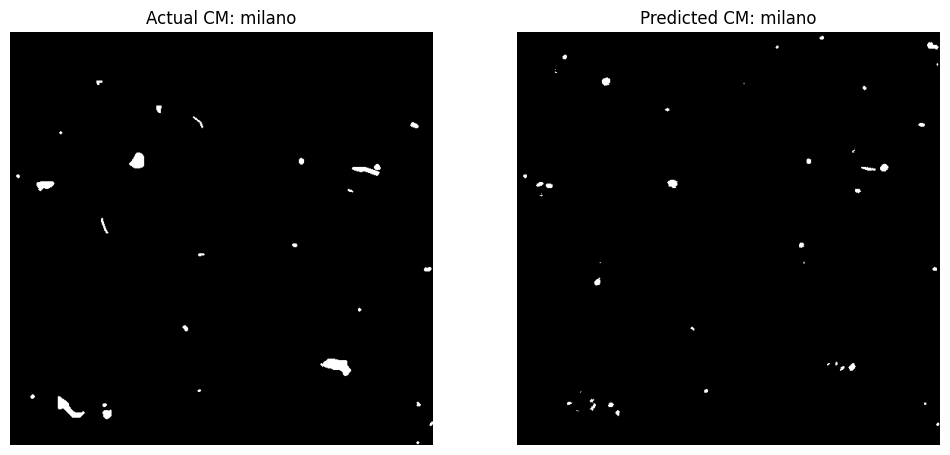

 50%|█████     | 5/10 [00:02<00:02,  2.33it/s]

Stage1torch.Size([1, 16, 213, 225])
Stage2torch.Size([1, 32, 106, 112])
Stage3torch.Size([1, 64, 53, 56])
Stage4torch.Size([1, 128, 26, 28])
Stage1torch.Size([1, 16, 213, 225])
Stage2torch.Size([1, 32, 106, 112])
Stage3torch.Size([1, 64, 53, 56])
Stage4torch.Size([1, 128, 26, 28])


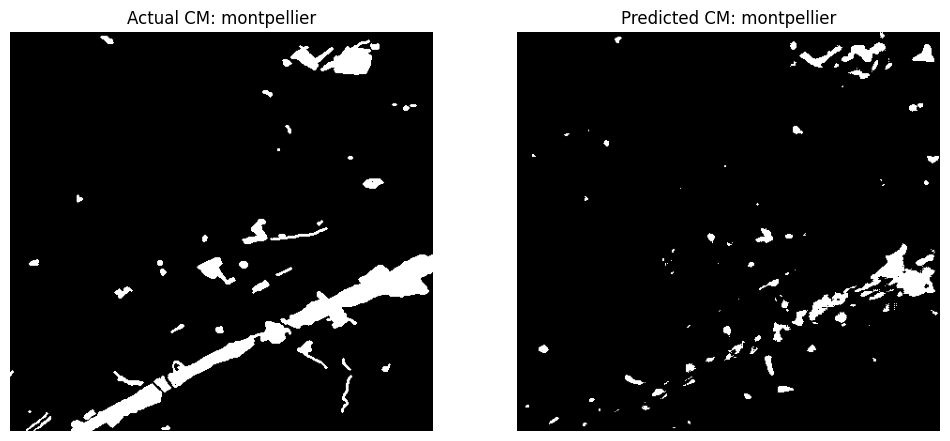

 60%|██████    | 6/10 [00:02<00:01,  2.52it/s]

Stage1torch.Size([1, 16, 120, 192])
Stage2torch.Size([1, 32, 60, 96])
Stage3torch.Size([1, 64, 30, 48])
Stage4torch.Size([1, 128, 15, 24])
Stage1torch.Size([1, 16, 120, 192])
Stage2torch.Size([1, 32, 60, 96])
Stage3torch.Size([1, 64, 30, 48])
Stage4torch.Size([1, 128, 15, 24])


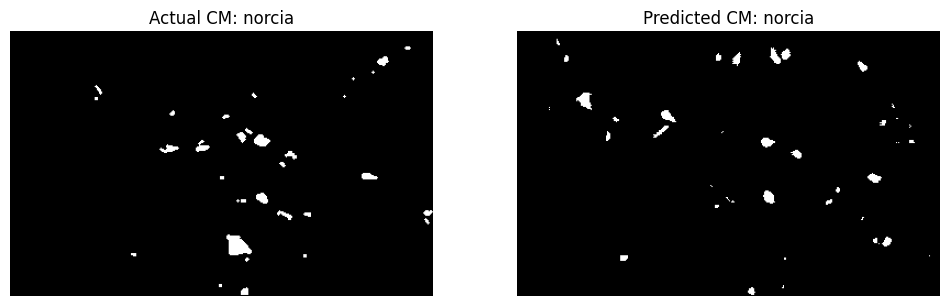

 70%|███████   | 7/10 [00:02<00:01,  2.87it/s]

Stage1torch.Size([1, 16, 176, 213])
Stage2torch.Size([1, 32, 88, 106])
Stage3torch.Size([1, 64, 44, 53])
Stage4torch.Size([1, 128, 22, 26])
Stage1torch.Size([1, 16, 176, 213])
Stage2torch.Size([1, 32, 88, 106])
Stage3torch.Size([1, 64, 44, 53])
Stage4torch.Size([1, 128, 22, 26])


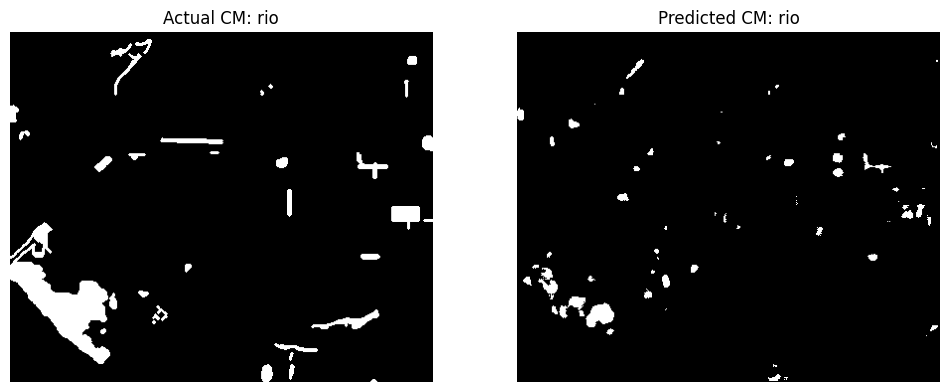

 80%|████████  | 8/10 [00:03<00:00,  3.08it/s]

Stage1torch.Size([1, 16, 319, 344])
Stage2torch.Size([1, 32, 159, 172])
Stage3torch.Size([1, 64, 79, 86])
Stage4torch.Size([1, 128, 39, 43])
Stage1torch.Size([1, 16, 319, 344])
Stage2torch.Size([1, 32, 159, 172])
Stage3torch.Size([1, 64, 79, 86])
Stage4torch.Size([1, 128, 39, 43])


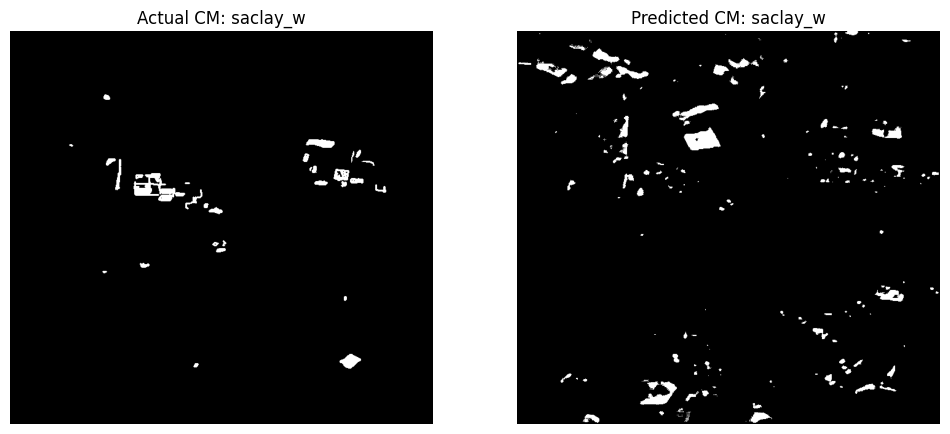

 90%|█████████ | 9/10 [00:03<00:00,  2.95it/s]

Stage1torch.Size([1, 16, 229, 238])
Stage2torch.Size([1, 32, 114, 119])
Stage3torch.Size([1, 64, 57, 59])
Stage4torch.Size([1, 128, 28, 29])
Stage1torch.Size([1, 16, 229, 238])
Stage2torch.Size([1, 32, 114, 119])
Stage3torch.Size([1, 64, 57, 59])
Stage4torch.Size([1, 128, 28, 29])


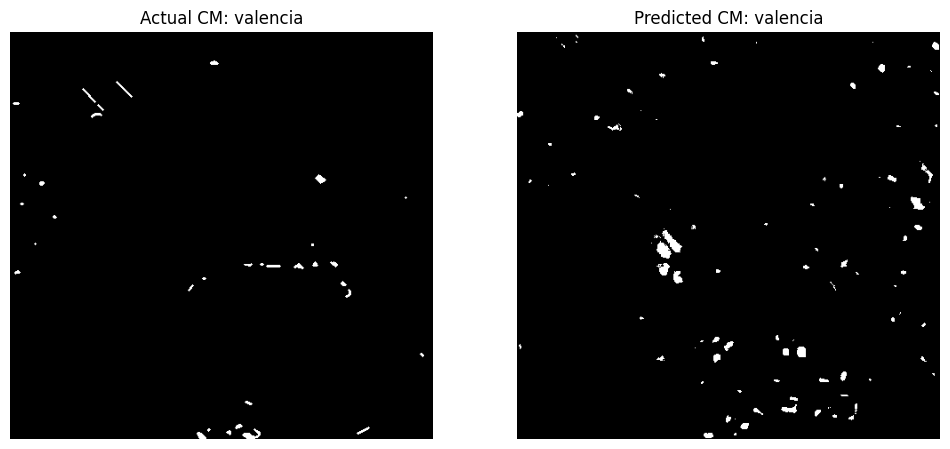

100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

Elapsed time: 3.8294475078582764


In [32]:
import matplotlib.pyplot as plt

def plot_change_maps(actual_cm, predicted_cm, title_actual="Actual Change Map", title_predicted="Predicted Change Map"):
    """Helper function to plot actual vs predicted change maps"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot actual change map
    axes[0].imshow(actual_cm, cmap='gray')
    axes[0].set_title(title_actual)
    axes[0].axis('off')

    # Plot predicted change map
    axes[1].imshow(predicted_cm, cmap='gray')
    axes[1].set_title(title_predicted)
    axes[1].axis('off')

    plt.show()

def save_test_results(dset):
    for name in tqdm(dset.names):
        with warnings.catch_warnings():
            # Retrieve image pair and change map
            I1, I2, cm = dset.get_img(name)
            I1 = (torch.unsqueeze(I1, 0).float()).cuda()
            I2 = (torch.unsqueeze(I2, 0).float()).cuda()

            # Get model prediction
            out = net(I1, I2)
            _, predicted = torch.max(out.data, 1)

            # Convert actual and predicted change maps to NumPy for plotting
            actual_cm = cm.astype(np.uint8) * 255  # Scaling to 0-255
            predicted_cm = np.squeeze(predicted.cpu().numpy()) * 255  # Squeeze and scale to 0-255

            # Plot actual vs predicted change maps
            plot_change_maps(actual_cm, predicted_cm, f"Actual CM: {name}", f"Predicted CM: {name}")

            # Optionally save the image comparison
            I = np.stack((actual_cm, predicted_cm, actual_cm), 2).astype(np.uint8)
            io.imsave(f'{net_name}-{name}.png', I)

t_start = time.time()
save_test_results(test_dataset)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))
